# Перенос обучения

## Загрузка библиотек

In [ ]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import os
import time
import glob

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import cv2

%matplotlib inline

##Часть I. Предобученные сети как экстракторы признаков	

## Загрузка данных

In [ ]:
path = "train/"

In [ ]:
# Мы создаем класс CustomDataset и передаем аргумент Dataset, 
# чтобы он мог наследовать функционал класса Torch Dataset

class CustomDataset(Dataset):
    def __init__(self, train_flag = 'train', my_path = path, fine_tuning = False):
        self.imgs_path = my_path
        self.data = []

        # Мы добавляем путь к файлу для каждого изображения в список self.data вместе с соответствующим именем класса. 
        for img_path in glob.glob(self.imgs_path + "/*.jpg"):
                class_name = img_path.split(".")[0].split("/")[-1]
                self.data.append([img_path, class_name])
        
        self.classes = ['dog', 'cat']
        self.class_map = {"dog" : 0, "cat": 1}
        self.img_dim = (224, 224)

        # Перемешаем данные
        random.shuffle(self.data) 

        if fine_tuning:
          data_train = 2000
          data_val = 3000

        else: 
          data_train = 200
          data_val = 300


        # Разделим выборку на обучающую и валидационную
        if train_flag == 'train':
          print(data_train)
          self.data = self.data[:data_train]
        elif train_flag == 'val':
          print(data_val)
          self.data = self.data[data_train:data_val]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]

        # Мы используем opencv, чтобы загрузить изображение и изменить его размер до необходимого размера
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)

        # Словарь self.class_map обеспечивает отображение имени класса в метку.
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)

        # Приведем скейлинг изображения: переведем пиксели от 0 до 255 к формату от 0 до 1 
        img_tensor = img_tensor/255
        img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

Параметр **train_flag** класса CustomDataset позволяет нам выбирать между обучающей и тестовой выборкой.

In [ ]:
train_data = CustomDataset()
val_data = CustomDataset('val')

batch_size = 4

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

200
300



Посмотрим на размер train_data с помощью метода __len__().

In [ ]:
train_data.__len__()

200

Отрисуем один батч картинок, загруженных с помощью DataLoader()

In [ ]:
X_train, y_train = next(iter(train_loader))
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))

In [ ]:
classes = train_data.classes
classes

['dog', 'cat']

['dog', 'cat', 'dog', 'dog']


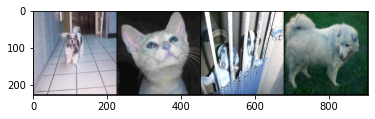

In [ ]:
print([classes[i] for i in y_train])
plt.imshow(img)

### Загрузка модели

Мы будем использовать VGG16 в качестве предобученной сети.

In [ ]:
from torchvision.models import vgg16

In [ ]:
model = vgg16(pretrained = True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Это значит, что мы будем использовать уже обученные веса данной нейронной сети.

Напомним, что веса можно получить в виде словаря "состояния" сети:

In [ ]:
#model.state_dict()

### Заморозка слоев VGG16 сети

In [ ]:
# Помним, что заморозка предполагает фиксацию весов модели во время обретного распространения ошибки 

for param in model.parameters():
    param.requires_grad = False

# Посмотрим, сколько нейронов подается на вход выходному слою классификатора
n_neurons = model.classifier[-1].in_features 
print(n_neurons)

# Заменим этот слой на новый, выходное количество нейронов которого соотвествует нашей задачи бинарной классификации
num_classes = 2
model.classifier[-1] = nn.Linear(n_neurons, num_classes)

4096


In [ ]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [ ]:
# Будем обучать только добавленный выходной слой классификатора
for index, param in enumerate(model.classifier.parameters()):
    if index == 6:
        param.requires_grad = True

In [ ]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
      device = 'cuda'
else:
      device = 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())

True


In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Обучение модели

Для удобства создадим словарь даталоадеров:

In [ ]:
dataloaders = {'train': train_loader,
               'val': val_loader}

In [ ]:
def train_model(model, device, dataloaders, criterion, optimizer, batch_size, fine_tuning = False, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # На каждой эпохе происходит обучение и валидая 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 
            
            current_loss = 0.0
            current_corrects = 0
            batch = 0

            # Проходим по данным
            for inputs, labels in dataloaders[phase]:
                batch += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуляем градиенты
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Получаем прогноз модели и считаем лосс
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.squeeze(-1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # считаем статистики
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels)
                
                # посмотрим на статистики на каждых 10 батчах
                if batch%10 == 0 and phase == "train":
                  print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                  batch, current_loss/(batch_size*batch), 100*current_corrects/(batch_size*batch)))

            epoch_loss = current_loss / CustomDataset(phase, fine_tuning = fine_tuning).__len__()
            epoch_acc = current_corrects.double() / CustomDataset(phase, fine_tuning = fine_tuning).__len__()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
    time_elapsed = time.time() - since
    print('Время обучения: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

In [ ]:
cat_vs_dog = train_model(model, device, dataloaders, criterion, optimizer, batch_size = batch_size, fine_tuning = False, num_epochs=1)

Epoch 0/0
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Batch 10, Train Loss:0.5024, Train ACC:67.5000
Batch 20, Train Loss:0.4074, Train ACC:77.5000
Batch 30, Train Loss:0.3288, Train ACC:82.5000
Batch 40, Train Loss:0.2937, Train ACC:83.7500
Batch 50, Train Loss:0.2679, Train ACC:86.0000
200
200
train Loss: 0.2679 Acc: 0.8600
300
300
val Loss: 0.2831 Acc: 0.8900
Время обучения: 0m 9s


### Визуализация модели

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    if use_gpu:
      device = 'cuda'
    else:
      device = 'cpu'

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                plt.imshow(img)

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

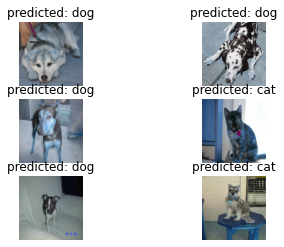

In [ ]:
visualize_model(cat_vs_dog)
plt.show()

-----

##Часть II. Тонкая настройка модели

In [ ]:
train_data_ft = CustomDataset(fine_tuning = True)
val_data_ft = CustomDataset('val', fine_tuning = True)

batch_size = 24

train_loader_ft = DataLoader(train_data_ft, batch_size=batch_size, shuffle=True)
val_loader_ft = DataLoader(val_data_ft, batch_size=batch_size, shuffle=True)

2000
3000


Отрисуем один батч картинок, загруженных с помощью DataLoader()

In [ ]:
def imshow(inp, title=None): 
    """Imshow for Tensor.""" 
    inp = inp.numpy().transpose((1, 2, 0)) 
    plt.figure(figsize=(15,10)) 
    plt.imshow(inp) 

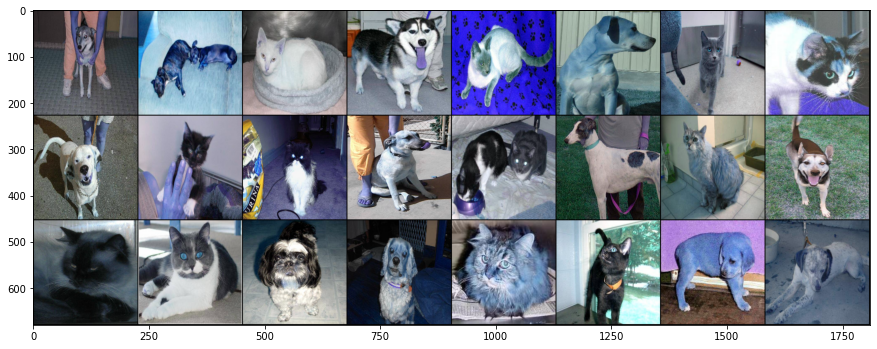

In [ ]:
X_train_ft, y_train_ft = next(iter(train_loader_ft))
img = torchvision.utils.make_grid(X_train_ft, scale_each= True)
imshow(img)

Инициализируем модель

In [ ]:
model = vgg16(pretrained = True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Настройка слоев VGG16 сети

In [ ]:
# Посмотрим, сколько нейронов подается на вход выходному слою классификатора
n_neurons = model.classifier[-1].in_features 
print(n_neurons)

# Заменим этот слой на новый, выходное количество нейронов которого соотвествует нашей задачи бинарной классификации
num_classes = 2
model.classifier[-1] = nn.Linear(n_neurons, num_classes)

4096


In [ ]:
# Настроим 3 последних сверточных слоя сети
for index, param in enumerate(model.features.parameters()):
    if index >= 24:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
      device = 'cuda'
else:
      device = 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

True


### Обучение модели

In [ ]:
dataloaders_ft = {'train': train_loader_ft,
                  'val': val_loader_ft}

In [ ]:
cat_vs_dog_finetuned = train_model(model, device, dataloaders_ft, criterion, optimizer,  batch_size=batch_size, fine_tuning = True, num_epochs=1)

Epoch 0/0
----------
Batch 10, Train Loss:1.1920, Train ACC:67.5000
Batch 20, Train Loss:0.7497, Train ACC:78.5417
Batch 30, Train Loss:0.5563, Train ACC:84.0278
Batch 40, Train Loss:0.4724, Train ACC:86.4583
Batch 50, Train Loss:0.4147, Train ACC:87.8333
Batch 60, Train Loss:0.3639, Train ACC:89.0972
Batch 70, Train Loss:0.3299, Train ACC:89.9405
Batch 80, Train Loss:0.3106, Train ACC:90.8854
2000
2000
train Loss: 0.2997 Acc: 0.9115
3000
3000
val Loss: 0.1439 Acc: 0.9590
Время обучения: 0m 53s


### Визуализация модели

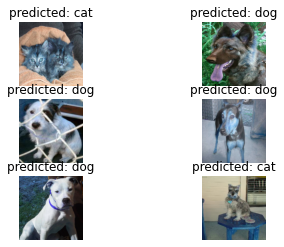

In [ ]:
visualize_model(cat_vs_dog_finetuned)
plt.show()

## Домашнее задание

Попробуйте изменить модель путем полной замены полносвязного классификатора на новый и добавлением аугментации данных. 

Сделайте сравнение полученных результатов, какая модель работает лучше и почему.

